In [ ]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


# Evaluate the model
def evaluate_model(X, y, model,smote = True):
    # K-Fold on the data
    time0 = time.time()
    cv = StratifiedKFold(n_splits=10)
    f2_scorer = make_scorer(fbeta_score, beta = 2.0)
    scoring = {'recall': 'recall',
            'f1_score': 'f1',
            'roc_auc': 'roc_auc',
            'f2beta':f2_scorer}
    if smote:
        over = SMOTE(sampling_strategy=0.1, k_neighbors=5, random_state=12)
        under = RandomUnderSampler(sampling_strategy = 0.8, random_state=12)
        steps = [("over", over), ("under", under), ("classifier",model)]
        pipeline = imbpipeline(steps = steps)
    else:
        pipeline = imbpipeline(steps = [['classifier',model]])
    scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1,verbose = 100)
    time_end = time0 - time.time()
    
    return scores, time_end

def extract_x_y(df):
    X = np.array(df.loc[:, df.columns != 'TARGET'])
    y = np.array(df.loc[:, df.columns == 'TARGET']).reshape(-1, 1)

    return X, y

def scale(X, y):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = y
    return X, y
    
    
def test_model(models,names, X, y, smote = True):
    results = {}
    dict_time = {}
    for i in range(len(models)):
        print(names[i])
        with timer("Test model :" + names[i]):
            if names[i] == "LR":
                X, y = scale(X, y)
            score, time = evaluate_model(X, y, models[i], smote = smote)
            
            results[names[i]] = [score["test_recall"].mean(),
                                score["test_f1_score"].mean(),
                                score["test_roc_auc"].mean(),
                                score["test_f2beta"].mean(),
                                time]
            print(names[i],pd.DataFrame.from_dict(score)[["test_recall","test_f1_score","test_roc_auc","test_f2beta"]].mean())
    return results
    
def get_models():
    models, names = list(), list()
    # SVM
    models.append(LogisticRegression(solver = "lbfgs", max_iter = 1000, random_state = 42))
    names.append('LR')
    
    models.append(xgb.XGBClassifier())
    names.append('XGB')
    
    models.append(MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1))
    names.append('MLP')
    
    models.append(LGBMClassifier())
    names.append('LGMB')
    
    return models, names
    
def full_test_pipeline(smote = True, test_size=0.95):

    df, _ = train_test_split(train_df, test_size=test_size, stratify=train_df['TARGET'], random_state=11)

    print("Test effectué sur ", df.shape, " données")   
    df = df.replace([np.inf, -np.inf], 0)    
    
    with timer("split_df"):
        X, y = extract_x_y(df)
        del df
        gc.collect()

    with timer ("Models"):
         models, names = get_models()
                  
    with timer("test_model"):
        results = test_model(models, names, X, y, smote = smote)
    return results


Avec le lancement de cette fonction nous arrivons à ces résultats  
Le roc_auc est sensiblement identique mais les autres métriques sont bien optimisées avec la balance des données

In [ ]:
results = results_pipeline_ns_df.join(results_pipeline_df, how ="left", on=None, rsuffix="_SM")
results

,test_recall,test_f1_score,test_roc_auc,test_f2beta,time,test_recall_SM,test_f1_score_SM,test_roc_auc_SM,test_f2beta_SM,time_SM
LR,0.033132,0.061938,0.765670,0.040704,112.965640,0.621752,0.286039,0.760408,0.423103,33.625179
XGB,0.064350,0.112145,0.761221,0.077572,242.767492,0.585901,0.284672,0.753700,0.411649,60.921040
MLP,0.154582,0.175467,0.649375,0.162092,481.493485,0.567372,0.226332,0.682286,0.353753,58.059823
LGMB,0.039980,0.074108,0.774302,0.049007,30.440036,0.600403,0.304574,0.772235,0.432392,17.389580


# Résultats des baselines

In [ ]:
def eval_k_smote(smote = False, best_k = False):
    model_lgbm = lgb.LGBMClassifier(n_jobs = -1, random_state = 42,
     objective = "binary",
     n_estimators = 10000)
                        
    f2_scorer = make_scorer(fbeta_score, beta = 2.0)
    fit_params={'lgbm__early_stopping_rounds': 100,
                'lgbm__eval_metric':"auc",   
                'lgbm__verbose': True,
                'lgbm__eval_set': eval_set}

    scoring = {'recall': 'recall',
           'f1_score': 'f1',
           'roc_auc': 'roc_auc'}
    
    if smote :
        over = SMOTE(sampling_strategy=0.20)
        under = RandomUnderSampler(sampling_strategy = 0.7)
        steps = [("over", over), ("under", under), ("lgbm",model_lgbm)]
        pipeline_smote = Pipeline(steps=steps)
        pipeline = pipeline_smote
        if best_k :
            k_values = [1,2,3,4,5,6,7] 
            for k in k_values:
                over = SMOTE(sampling_strategy=0.20, k_neighbors=k)
                under = RandomUnderSampler(sampling_strategy = 0.7)
                steps = [("over", over), ("under", under), ("lgbm",model_lgbm)]
                pipeline_smote = Pipeline(steps=steps)
                pipeline = pipeline_smote
                cv_results = cross_validate(pipeline, train_x, train_y, 
                                            cv = cv, 
                                            scoring = scoring, 
                                            fit_params = fit_params, 
                                            n_jobs=-1, 
                                            error_score='raise')
                print("for k = ",k, pd.DataFrame.from_dict(cv_results).mean())

        else:
            cv_results = cross_validate(pipeline, train_x, train_y, 
                                            cv = cv, 
                                            scoring = scoring, 
                                            fit_params = fit_params, 
                                            n_jobs=-1, 
                                            error_score='raise')
        print(pd.DataFrame.from_dict(cv_results).mean())

    else:
        pipeline = Pipeline([("lgbm",model_lgbm)])
        cv_results = cross_validate(pipeline, train_x, train_y, 
                                            cv = cv, 
                                            scoring = scoring, 
                                            fit_params = fit_params, 
                                            n_jobs=-1, 
                                            error_score='raise')
        print(pd.DataFrame.from_dict(cv_results).mean())

## Sans balance

In [ ]:
eval_k_smote(smote = False)

fit_time         26.726419
score_time        1.009668
test_recall       0.041793
test_f1_score     0.077515
test_roc_auc      0.779373
dtype: float64


## Avec balance

In [ ]:
eval_k_smote(smote = True)


fit_time         41.210590
score_time        1.195398
test_recall       0.317221
test_f1_score     0.312033
test_roc_auc      0.778377
dtype: float64


# Cout métier

Après sélection des features et optimisation des paramètres

In [ ]:
# Recherche des meilleurs seuils avec un coût métier

annuity_mean = new_train["AMT_ANNUITY"].mean()
loan_mean = new_train["AMT_CREDIT"].mean()
positive = len(valid_y[valid_y == 1])
negative = len(valid_y[valid_y == 0])
#Make the more money
scoring1 = ((1-fpr)*annuity_mean*negative) - ((1-tpr)*loan_mean*positive)
#Make money and save the more customers
scoring2 = ((1-fpr)*annuity_mean*negative) - ((1-tpr)*loan_mean*positive) - (fpr * annuity_mean*negative)

## Sans balance

Le seuil est très rabaissé pour avoir un cout métier qui soit bon (4.1 %)

Best Threshold=0.041476, scoring=376926807.416
Accuracy score for Testing Dataset =  0.5208611102077981
Roc auc score for Testing Dataset =  0.6820705334960444
Fbeta score for Testing Dataset =  0.40918088415496273
F1 score for Testing Dataset =  0.22757536041939713
Recall score for Testing Dataset =  0.8743202416918429


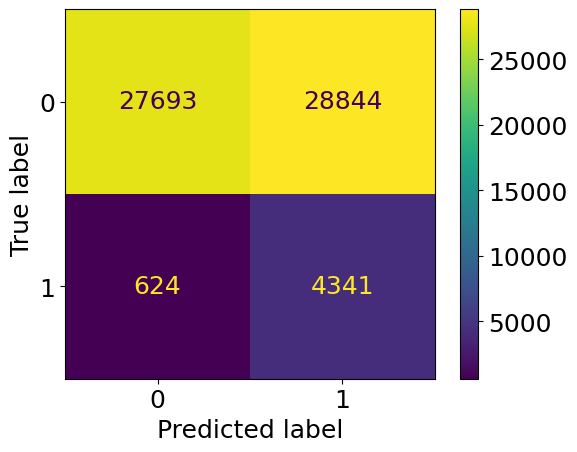

Bon crédit accordé: 27693
Perte de bons clients: 28844 soit 51.02 %
Mauvais crédit accordé: 624 soit 12.57 %
benefit :  376926807.0
Loose for credit refused : 781922741.0
save_money for credit refused :  2600383138.0


In [ ]:
# best balance profit / loose
ix = np.argmax(scoring1)
print('Best Threshold=%f, scoring=%.3f' % (thresholds[ix], scoring1[ix]))
test_pred_tresh = (model.predict_proba(valid_x)[:,1] >= thresholds[ix]).astype(int) 
results(valid_y, test_pred_tresh)
best_tresh_scoring1 = thresholds[ix]

## Avec balance

Moins de mauvais crédit sont acceptés et le seuil se retrouve beaucoup plus haut (25%)
Cependant le bénéfice coût métier est légèrement plus bas

Best Threshold=0.251173, scoring=375666329.052
Accuracy score for Testing Dataset =  0.5077558453383629
Roc auc score for Testing Dataset =  0.6782494601428565
Fbeta score for Testing Dataset =  0.4058564990820245
F1 score for Testing Dataset =  0.22430050220354616
Recall score for Testing Dataset =  0.881570996978852


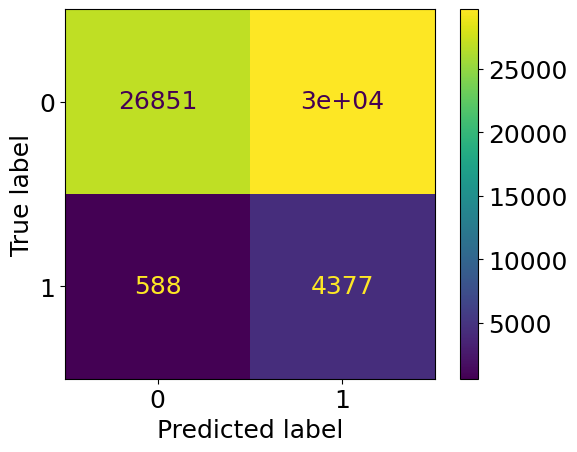

Bon crédit accordé: 26851
Perte de bons clients: 29686 soit 52.51 %
Mauvais crédit accordé: 588 soit 11.84 %
benefit :  375666329.0
Loose for credit refused : 804748249.0
save_money for credit refused :  2621948168.0


In [ ]:
# best balance profit / loose
ix = np.argmax(scoring1)
print('Best Threshold=%f, scoring=%.3f' % (thresholds[ix], scoring1[ix]))
test_pred_tresh = (model.predict_proba(valid_x)[:,1] >= thresholds[ix]).astype(int) 
results(valid_y, test_pred_tresh)
best_tresh_scoring1 = thresholds[ix]